In [2]:
import os
os.chdir('/Users/ngdnhtien/Codespace/bqec@huikhoon')

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import math
import utility as ut 
from scipy.optimize import minimize

%config InlineBackend.figure_formats = ['svg']

In [4]:
pi = np.pi

# Reproduce the original results

## Method 1: Fitting eigen-energies

In [127]:
dimCavity = 30
dimAncilla = 5

c = qt.tensor(qt.destroy(dimAncilla), qt.qeye(dimCavity))
a = qt.tensor(qt.qeye(dimAncilla), qt.destroy(dimCavity))

n_a = a.dag() * a 
n_c = c.dag() * c

In [128]:
# Baseline parameters
omega_10 = (2*pi)*4.936
alpha = (2*pi)*0.168
omega_c = omega_10 + alpha

def H_RWA(r1, r2, r3, r4_squared):

    delta_a = r1 * alpha
    g_a = -1j* r2 * delta_a 
    delta_d = r3 * alpha 
    Omega_d = np.sqrt(r4_squared) * delta_d 

    omega_c = omega_10 + alpha 
    omega_d = omega_10 + delta_d 
    omega_a = omega_10 + delta_a

    delta_da = omega_d - omega_a
    delta_dc = omega_d - omega_c 

    params = {'delta_a': delta_a, 'g_a': g_a, 'delta_d': delta_d, 'Omega_d': Omega_d, 'omega_d': omega_d, 'omega_a': omega_a}

    H_RWA_cav = - delta_da * a.dag() * a 
    H_RWA_anc = - delta_dc * c.dag() * c - (alpha/2) * (c.dag()*c + 1) * c.dag() * c + (Omega_d * c.dag() + np.conj(Omega_d) * c)
    H_RWA_int = g_a * a * c.dag() + np.conj(g_a) * a.dag() * c

    return H_RWA_cav + H_RWA_anc + H_RWA_int, params

In [129]:
H_uncoupled, params = H_RWA(9.64, 0, 0.08, 0)

uncoupled_eig_energies, uncoupled_eig_states = H_uncoupled.eigenstates()

In [130]:
params

{'delta_a': 10.175744268683484,
 'g_a': 0j,
 'delta_d': 0.08444601052849364,
 'Omega_d': 0.0,
 'omega_d': 31.098248686766933,
 'omega_a': 41.18954694492192}

#### Step 1. We label the uncoupled states using basis Fock number states

In [131]:
basis_state = []

for NC in range(dimAncilla):
    for NA in range(dimCavity):
        basis_state.append([qt.tensor(qt.basis(dimAncilla, NC), qt.basis(dimCavity, NA)), [NC, NA]])

labelled_uncoupled_states = []

for eig_state in uncoupled_eig_states:
    max_fidelity = 0
    for state in basis_state:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_uncoupled_states.append([eig_state, label_eig_state])

In [132]:
# We sort the list of uncoupled states 

sorted_labelled_uncoupled_states = sorted(labelled_uncoupled_states, key=lambda x: x[1])

#### Step 2. Turn on coupling and label the entangled states using labelled uncoupled states 

In [133]:
H_entangled, params = H_RWA(9.64, 0.064, 0.08, 0)

entangled_eig_energies, entangled_eig_states = H_entangled.eigenstates()

In [134]:
labelled_entangled_states = []

for eig_state in entangled_eig_states:
    max_fidelity = 0
    for state in labelled_uncoupled_states:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_entangled_states.append([eig_state, label_eig_state])

In [135]:
sorted_labelled_entangled_states = sorted(labelled_entangled_states, key=lambda x: x[1])

#### Step 3. Find the $U_d$

In [136]:
U_d = np.zeros([len(sorted_labelled_entangled_states), len(sorted_labelled_entangled_states)], dtype=complex)

for i in range(len(sorted_labelled_uncoupled_states)):
    for j in range(len(sorted_labelled_entangled_states)):
        complex_val = (sorted_labelled_uncoupled_states[i][0].dag() * sorted_labelled_entangled_states[j][0]).full()[0][0]
        U_d[i, j] = complex_val

U_d = qt.Qobj(U_d, dims=[[dimAncilla,dimCavity],[dimAncilla,dimCavity]])
U_d.check_isunitary()

True

#### Step 4. Obtain $N_A$

In [137]:
A = U_d * a * U_d.dag()
N_A = U_d * (a.dag()*a) * U_d.dag()

#### Step 5. Fit

In [138]:
sorted_labelled_entangled_states = np.array(sorted_labelled_entangled_states, dtype=object)

fit_states = []
fit_label = []

for state in sorted_labelled_entangled_states:
    if state[1][0] == 0:
        fit_states.append(state)
        fit_label.append(state[1][1])

fit_label = np.array(fit_label)
fit_eig_energies = []

for state in fit_states:
    energy = state[0].dag()*H_entangled*state[0]
    fit_eig_energies.append(np.real(energy.full()[0][0]))

fit_eig_energies = np.array(fit_eig_energies)

In [140]:
fit_eig_energies

array([  0.        ,  10.13280877,  20.26560111,  30.39837706,
        40.53113665,  50.66387991,  60.7966069 ,  70.92931764,
        81.06201216,  91.19469051, 101.32735272, 111.45999883,
       121.59262886, 131.72524286, 141.85784086, 151.99042288,
       162.12298897, 172.25553916, 182.38807348, 192.52059197,
       202.65309464, 212.78558154, 222.9180527 , 233.05050814,
       243.18294789, 253.31537199, 263.44778047, 273.58017334,
       283.71255064, 293.8449124 ])

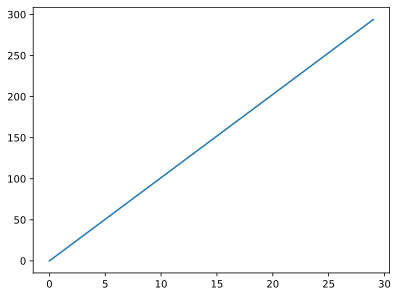

In [110]:
plt.plot(fit_label, fit_eig_energies)

In [120]:
popt, _, _ = ut.fit_function(
    fit_label, fit_eig_energies, # try to subtract to the second order
    lambda x, c1, c2, c3, c4: ( c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4),
    [0, 0, 0, 0]
)

In [124]:
print(r'The self-Kerr fitted value K_A = '+f'{np.round(popt[1]*pi, 10)/1e-3}'+' kHz')

The self-Kerr fitted value K_A = -0.025899 kHz


### Now we try different values of $r_4$

In [343]:
def compute_Kerr(dim_a, dim_c, omega_10, alpha, r1, r2, r3, r4):
    
    a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
    c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

    delta_a = r1 * alpha
    g_a = -1j * r2 * delta_a 
    delta_d = r3 * alpha 
    Omega_d = r4 * delta_d

    omega_d = omega_10 + delta_d 
    omega_a = omega_10 + delta_a 

    params = {'delta_a': delta_a, 'g_a': g_a, 'delta_d': delta_d, 'Omega_d': Omega_d, 'omega_d': omega_d, 'omega_a': omega_a}

    H_RWA_cav = - (omega_d - omega_a) * a.dag() * a 
    H_RWA_anc = - (omega_d - omega_c) * c.dag() * c - (alpha/2) * (c.dag()*c + 1) * c.dag() * c + (Omega_d * c.dag() + np.conj(Omega_d) * c)
    H_RWA_int = g_a * a * c.dag() + np.conj(g_a) * a.dag() * c

    H_uncoupled = H_RWA_cav + H_RWA_anc

    _, uncoupled_eig_states = H_uncoupled.eigenstates()
    
    basis_state = []

    for NA in range(dim_a):
        for NC in range(dim_c):
            basis_state.append([qt.tensor(qt.basis(dim_a, NA), qt.basis(dim_c, NC)), [NA, NC]])

    labelled_uncoupled_states = []

    for eig_state in uncoupled_eig_states:
        max_fidelity = 0
        for state in basis_state:
            fidelity = qt.fidelity(state[0], eig_state)
            if fidelity > max_fidelity:
                max_fidelity = fidelity 
                label_eig_state = state[1]
        labelled_uncoupled_states.append([eig_state, label_eig_state])

    H_entangled = H_uncoupled + H_RWA_int

    _, entangled_eig_states = H_entangled.eigenstates()

    labelled_entangled_states = []

    for eig_state in entangled_eig_states:
        max_fidelity = 0
        for state in labelled_uncoupled_states:
            fidelity = qt.fidelity(state[0], eig_state)
            if fidelity > max_fidelity:
                max_fidelity = fidelity 
                label_eig_state = state[1]
        labelled_entangled_states.append([eig_state, label_eig_state])
    
    sorted_labelled_entangled_states = sorted(labelled_entangled_states, key=lambda x: x[1])

    sorted_labelled_entangled_states = np.array(sorted_labelled_entangled_states, dtype=object)

    fit_states = []
    fit_label = []

    for state in sorted_labelled_entangled_states:
        if state[1][1] == 0:
            fit_states.append(state)
            fit_label.append(state[1][0])

    fit_label = np.array(fit_label)
    fit_eig_energies = []

    for state in fit_states:
        energy = state[0].dag()*H_entangled*state[0]
        fit_eig_energies.append(np.real(energy.full()[0][0]))

    fit_eig_energies = np.array(fit_eig_energies)
    fit_eig_energies = fit_eig_energies - fit_eig_energies[0]
    popt, _, _ = ut.fit_function(
        fit_label[:-1], fit_eig_energies[:-1], # try to subtract to the second order
        lambda x, c1, c2, c3, c4: (c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4),
        [0, 1e-6, 1e-7, 1e-8])
    
    return popt, params

In [344]:
# Hilbert space truncation
dim_a = 30
dim_c = 20

# Baseline parameters
omega_10 = 4.936
alpha = 0.168

r1 = 9.64
r2 = 0.064
r3 = 0.08
r4_squared_list = np.linspace(0, 2.0, 25)

In [345]:
coeff_list = []
param_list = []
for r4 in r4_squared_list:
    r4 = np.sqrt(r4)
    coeffs, params = compute_Kerr(dim_a, dim_c, omega_10, alpha, r1, r2, r3, r4)
    coeff_list.append(coeffs)
    param_list.append(params)

In [346]:
coeff_list = np.array(coeff_list)

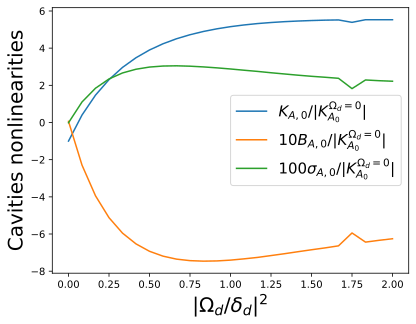

In [347]:
plt.plot(r4_squared_list, (coeff_list[:, 1]/np.abs(coeff_list[:, 1][0])), label='$K_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.plot(r4_squared_list, (math.factorial(3)*1e1*coeff_list[:, 2]/np.abs(coeff_list[:, 1][0])), label='$10B_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.plot(r4_squared_list, (math.factorial(4)*1e2*coeff_list[:, 3]/np.abs(coeff_list[:, 1][0])), label='$100\sigma_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.legend(fontsize=15)
plt.xlabel('$|\Omega_d/\delta_d|^2$', fontsize=20)
plt.ylabel('Cavities nonlinearities', fontsize=20)
plt.savefig('./30_20_4th_order.png', dpi=300)

In [335]:
# Hilbert space truncation
dim_a = 50
dim_c = 25

# Baseline parameters
omega_10 = 4.936
alpha = 0.168

r1 = 9.64
r2 = 0.064
r3 = 0.26
r4_squared_list = np.linspace(0, 1.0, 25)

In [336]:
coeff_list = []
param_list = []
for r4 in r4_squared_list:
    r4 = np.sqrt(r4)
    coeffs, params = compute_Kerr(dim_a, dim_c, omega_10, alpha, r1, r2, r3, r4)
    coeff_list.append(coeffs)
    param_list.append(params)

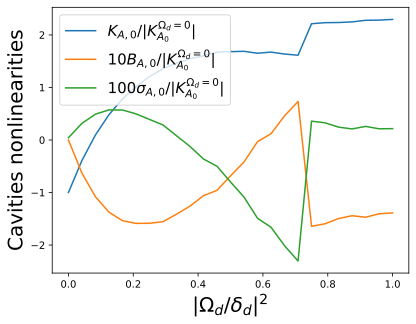

In [338]:
coeff_list = np.array(coeff_list)
plt.plot(r4_squared_list, (coeff_list[:, 1]/np.abs(coeff_list[:, 1][0])), label='$K_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.plot(r4_squared_list, (math.factorial(3)*1e1*coeff_list[:, 2]/np.abs(coeff_list[:, 1][0])), label='$10B_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.plot(r4_squared_list, (math.factorial(4)*1e2*coeff_list[:, 3]/np.abs(coeff_list[:, 1][0])), label='$100\sigma_{A,0}/|K^{\Omega_d=0}_{A_0}|$')
plt.legend(fontsize=15)
plt.xlabel('$|\Omega_d/\delta_d|^2$', fontsize=20)
plt.ylabel('Cavities nonlinearities', fontsize=20)
plt.savefig('./50_25_5th_order_figb.png', dpi=300)

## Method 2: Emulating a real experiment

---

In [497]:
dim_a = 20
dim_c = 15

a = qt.tensor(qt.destroy(dim_a), qt.qeye(dim_c))
c = qt.tensor(qt.qeye(dim_a), qt.destroy(dim_c))

def phi(EJ, EC):
    return (8*EC/EJ)**(1/4)*(c+c.dag())/np.sqrt(2)

def n(EJ, EC):
    return -1j*(8*EC/EJ)**(-1/4)*(c-c.dag())/np.sqrt(2) 

def H_cav(omega_a):
    return (omega_a)*a.dag()*a

In [500]:
qt.destroy(dim_a).dag()

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = False
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         1.41421356 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         1.73205081 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         2.         0.         0.
  0.         0.         0

In [489]:
# Baseline parameters
omega_10 = 4.936
alpha = 0.168
omega_c = omega_10 + alpha

# From the baseline parameters, EJ and EC can be approximated as
EC = alpha 
EJ = (omega_10+alpha)**2/(8*alpha)

r1 = 9.64
delta_a = r1 * alpha
omega_a = delta_a + omega_10 

r2 = 0.08
delta_d = r2 * alpha 
omega_d = delta_d + omega_10 

r4 = 0.064
g_a = -1j * r4 * delta_a

In [490]:
def H_eff(t, args):
    """ 
        Time-dependent coefficents
    """
    r3 = args['r3']
    theta_d = args['theta_d']

    Omega_d = (r3 * delta_d) * np.exp(-1j*theta_d)

    return Omega_d * np.exp(-1j*omega_d*t) - np.conj(Omega_d) * np.exp(1j*omega_d*t)

In [491]:
def H(couplingOn, driveOn):

    couplingSwitch = 0

    if couplingOn == True:
        couplingSwitch = 1
    
    H_static = H_cav(omega_a) + 4*alpha*n(EJ, EC)**2 - (omega_c**2/(8*alpha))*phi(EJ,EC).cosm() - couplingSwitch * g_a * (c - c.dag()) * (a + a.dag())
    H_drive = [(c-c.dag()), H_eff]

    if driveOn == True:
        return [H_static, H_drive]
    
    else: 
        return H_static

### Labelling product states

In [462]:
basis_state = []

for NA in range(dim_a):
    for NC in range(dim_c):
        basis_state.append([qt.tensor(qt.basis(dim_a, NA), qt.basis(dim_c, NC)), [NA, NC]])

In [463]:
H_uncoupled = H(couplingOn=False, driveOn=False)

uncoupled_eig_energies, uncoupled_eig_states = H_uncoupled.eigenstates()

In [464]:
labelled_prod_states = []

for eig_state in uncoupled_eig_states:
    max_fidelity = 0
    for state in basis_state:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_prod_states.append([eig_state, label_eig_state])

### Now we turn on the coupling and label the coupled states

In [465]:
H_coupled = H(couplingOn=True, driveOn=False)

coupled_eig_energies, coupled_eig_states = H_coupled.eigenstates()

In [466]:
labelled_coupled_states = []

for eig_state in coupled_eig_states:
    max_fidelity = 0
    for state in labelled_prod_states:
        fidelity = qt.fidelity(state[0], eig_state)
        if fidelity > max_fidelity:
            max_fidelity = fidelity 
            label_eig_state = state[1]
    labelled_coupled_states.append([eig_state, label_eig_state])

In [467]:
ordered_labelled_coupled_states = []
for NA in range(dim_a):
    for state in labelled_coupled_states:
        if state[1][0] == NA and state[1][1] == 0:
            ordered_labelled_coupled_states.append(state[0])

#### As a sanity check, let us construct a dressed Schrodinger cat state $\mathcal{N}(|\alpha\rangle+|-\alpha\rangle)$

In [468]:
def dressed_coherent(alpha):
    """
        Construct a coherent state
    """

    state = 0
    for n in range(dim_a):
        state += (alpha**n)*ordered_labelled_coupled_states[n]/np.sqrt(math.factorial(n))
    state = np.exp(-np.abs(alpha)**2/2)*state
    
    return state

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

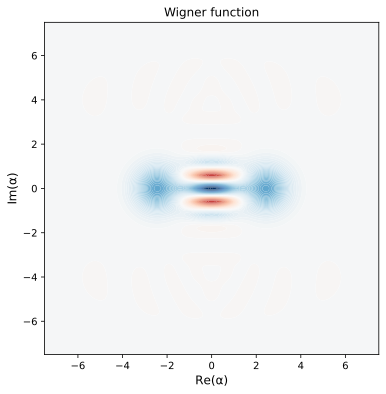

In [469]:
plus_cat = dressed_coherent(np.sqrt(3))
minus_cat = dressed_coherent(-np.sqrt(3))

cat = (plus_cat+minus_cat).unit()

qt.plot_wigner(cat.ptrace(0))

### Now we let this state evolve under the full Hamiltonian

In [430]:
options = qt.solver.Options()
options.nsteps = 500000
print(options)

Options:
-----------
atol:              1e-08
rtol:              1e-06
method:            adams
order:             12
nsteps:            500000
first_step:        0
min_step:          0
max_step:          0
tidy:              True
num_cpus:          8
norm_tol:          0.001
norm_steps:        5
rhs_filename:      None
rhs_reuse:         False
seeds:             0
rhs_with_state:    False
average_expect:    True
average_states:    False
ntraj:             500
store_states:      False
store_final_state: False



In [431]:
psi0 = cat
H_tot = H_coupled
times = np.arange(0, 50000, 40)

res = qt.mesolve(H=H_tot, rho0=psi0, tlist=times, c_ops=None, e_ops=None, args=None, options=options)

In [433]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(9, 3))

qt.plot_wigner(cat.ptrace(0), fig=fig, ax=ax1)
qt.plot_wigner(res.states[int(len(times)/2)].ptrace(0), fig=fig, ax=ax2)
qt.plot_wigner(res.states[-1].ptrace(0), fig=fig, ax=ax3)
ax1.set_title(r'$|\psi_0\rangle$')
ax2.set_title(r'At $t=\tau/2$')
ax3.set_title(r'At $t=\tau$')

fig.tight_layout()
#fig.savefig('./fig:wigner2.png', dpi=300)

### Construct the $N_a$ operator

In [483]:
N_a = 0

for n in range(dim_a):
    N_a += n * ordered_labelled_coupled_states[n] * ordered_labelled_coupled_states[n].dag()

N_a_2 = a.dag()*a 

In [485]:
N_a.ptrace(0)

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[ 3.90833764e-03  0.00000000e+00  5.90787476e-04  0.00000000e+00
   3.47712350e-08  0.00000000e+00  3.62303175e-12  0.00000000e+00
  -2.63816807e-12  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.01153418e+00  0.00000000e+00  1.02144157e-03
   0.00000000e+00  7.75168036e-08  0.00000000e+00  4.78922645e-12
   0.00000000e+00 -9.15466715e-12  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.90787476e-04  0.00000000e+00  2.01913137e+00  0.00000000e+00
   1.44195619e-03  0.00000000e+00  1.33855358e-07  0.00000000e+00
   1.47061936e-11  0.00000000e+00 -1.25278232e-12  0.00000000e+00
  -1.20479778e-12  0.00000000e+00  0.00000000e

In [496]:
a.dag().ptrace(0)

Quantum object: dims = [[20], [20]], shape = (20, 20), type = oper, isherm = False
Qobj data =
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [15.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         21.21320344  0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         25.98076211  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.

#### Effective Hamiltonian

In [476]:
def objective(args):

    c1, c2, c3 = args 
    H_eff = c1 * N_a + c2 * N_a**2 + c3 * N_a**3

    infd_list = []

    for idx, t in enumerate(times):
        evol_state = ((-1j*H_eff*times[idx]).expm() * psi0).unit()
        infd = np.abs(1 - qt.fidelity(evol_state, res.states[idx]))
        infd_list.append(infd)
        
    print(np.average(infd_list))
    return np.average(infd_list)

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

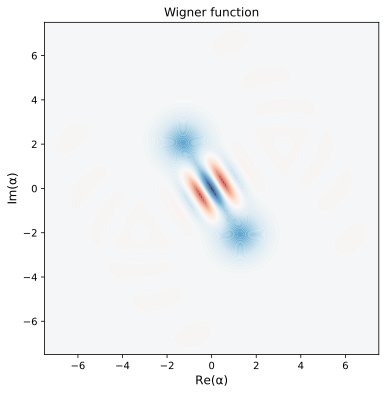

In [482]:
N_a = a.dag()*a 
x0 = [10, 2e-6, 1e-7]
H_eff = x0[0] * N_a + x0[1] * N_a**2 + x0[2] * N_a**3
evol_state = (-1j*H_eff*times[1]).expm() * psi0

qt.plot_wigner(evol_state.ptrace(0))

In [478]:
qt.fidelity(res.states[1], evol_state)

0.4855689469077892

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

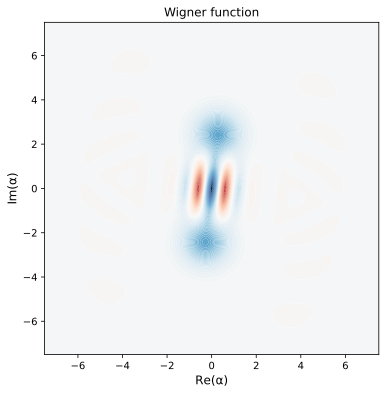

In [479]:
qt.plot_wigner(res.states[1].ptrace(0))

In [480]:
x0 = [-6.5, 1e-6, 1e-7]

solution = minimize(objective, x0, method='Nelder-Mead', tol=1e-7)

KeyboardInterrupt: 

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

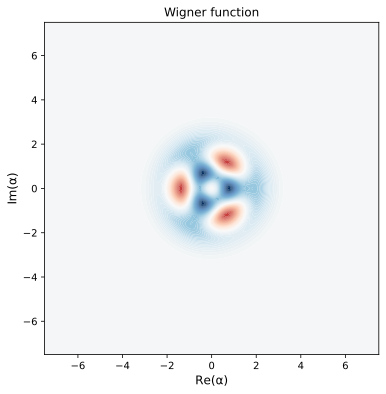

In [365]:
qt.plot_wigner((qt.basis(20, 0)+qt.basis(20, 3)).unit())

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

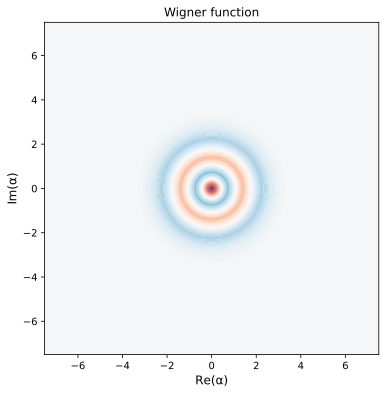

In [369]:
qt.plot_wigner(qt.basis(4, 3))